# Convertible Bond Valuation - Convergence Analysis

Value a Convertible Bond using a Tree-Based model that incorporates the conversion option as well as the call and puts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from financepy.utils import *
from financepy.products.bonds import *
from financepy.market.curves import *

####################################################################
# FINANCEPY BETA Version 0.33 - This build:  11 Nov 2023 at 07:47 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



## Creating the Convertible Bond

We set the maturity date, annualised coupon, coupon annual_frequency and convention for calculating accrued interest

In [3]:
maturity_date = Date(20, 3, 2023)
coupon = 0.0
freq_type = FrequencyTypes.SEMI_ANNUAL
accrualBasis = DayCountTypes.ACT_365F

We need to set the face amount and the conversion ratio. This is the number of shares you can convert to for that face amount.

In [4]:
face = 100.0 
conversion_ratio = 5.0  # Number of shares for face amount

We can also delay the start of the conversion feature using the start convert date

In [5]:
start_convert_date = Date(20, 12, 2019)

We can also set the call schedule - the price and date on which the issuer can call back the bond. This is given with reference to a price of 100. Making the call price very high means it will never be called. So the call has no impact.

In [6]:
call_price = 120 # Make call uneconomic so it does not impact pricing
call_dates = [Date(20, 3, 2020), Date(20, 3, 2021), Date(20, 3, 2022)]
call_prices = [call_price, call_price, call_price]

We can also set the put schedule - the price and date on which the owner can put back the bond to the issuer. This is given with reference to a price of 100. Making the put price very low means it will never be put.

In [7]:
putPrice = 0.0 # Make call uneconomic so it does not impact pricing
put_dates = [Date(20, 3, 2020), Date(20, 3, 2021), Date(20, 3, 2022)]
put_prices = [putPrice, putPrice, putPrice]

At this point we can create our bond.

In [9]:
bond = BondConvertible(maturity_date, coupon, freq_type, start_convert_date, conversion_ratio, call_dates, call_prices, put_dates, put_prices, accrualBasis)

# Valuation

### No Calls and Puts

We need to specify the valuation date

In [10]:
settle_date = Date(31, 12, 2019)

The model allows a discrete dividend schedule. We can use the FinSchedule class to do this.

In [11]:
dividendSchedule = Schedule(settle_date, maturity_date).schedule_dates()[1:]
dividend_yields = [0.01] * len(dividendSchedule)

We then need to set up the market inputs. 

In [12]:
stock_price = 20
stock_volatility = 0.30 # 30 percent
rate = 0.05
discount_curve = DiscountCurveFlat(settle_date, rate, FrequencyTypes.ANNUAL)
credit_spread = 0.00
recovery_rate = 0.40 # 40 percent

The model is a binomial tree but you don't need to enter any tree details unless you want to as it defaults to 100 steps per year

We can now peform the valuation

In [13]:
bond.value(settle_date, stock_price, stock_volatility, dividendSchedule, dividend_yields,
           discount_curve, credit_spread, recovery_rate)

{'cbprice': 109.73448110070586,
 'bond': 85.46491653997575,
 'delta': 2.9878835339742738,
 'gamma': 1.001353265428514,
 'theta': 109.31345846037485}

'cbrice' is the bond price. 'bond' is the price of the bond alone without any conversion and without any puts or calls option

## Impact of Calls

In [14]:
call_price = 100000.0
call_prices = [call_price, call_price, call_price]

Need to recreate the convertible bond.

In [16]:
bond = BondConvertible(maturity_date, coupon, freq_type, start_convert_date, conversion_ratio, call_dates, call_prices, put_dates, put_prices, accrualBasis)

In [17]:
bond.value(settle_date, stock_price, stock_volatility, dividendSchedule, dividend_yields,
           discount_curve, credit_spread, recovery_rate)

{'cbprice': 111.4282617425936,
 'bond': 85.46491653997575,
 'delta': 3.4297479279504275,
 'gamma': 0.817378351037334,
 'theta': 125.92922284966545}

## Stock Price Sensitivity

As the stock price goes up, the conversion options becomes more valuable

In [18]:
stock_prices = np.linspace(0,40,11)
print("%9s %12s %12s %12s"% ("StockPx", "CB Price", "Bond Price", "Delta"))

for stock_price in stock_prices:
    res = bond.value(settle_date, stock_price, stock_volatility, dividendSchedule, dividend_yields,
                     discount_curve, credit_spread, recovery_rate)
    print("%9.2f %12.4f %12.4f %12.4f"% (stock_price, res['cbprice'], res['bond'], res['delta']))

  StockPx     CB Price   Bond Price        Delta
     0.00      85.4649      85.4649       0.0000
     4.00      85.4819      85.4649       0.0282
     8.00      86.4021      85.4649       0.5501
    12.00      90.6543      85.4649       1.5947
    16.00      99.1995      85.4649       2.6294
    20.00     111.4283      85.4649       3.4297
    24.00     126.3526      85.4649       3.9905
    28.00     143.1370      85.4649       4.3776
    32.00     161.2960      85.4649       4.6745
    36.00     180.4177      85.4649       4.8710
    40.00     200.0973      85.4649       4.9645


As expected the price rises with increasing stock price as the conversion option is more valuable

## Convergence Testing

Set up the bond description

In [19]:
settle_date = Date(31, 12, 2019)

In [20]:
maturity_date = Date(20, 3, 2023)
coupon = 0.0
freq_type = FrequencyTypes.SEMI_ANNUAL
accrualBasis = DayCountTypes.ACT_365F

call_price = 100000.0 # Make call uneconomic so it does not impact pricing
call_dates = [] # [Date(20, 3, 2020)]
call_prices = [] # [call_price]

putPrice = 0.0 # Make call uneconomic so it does not impact pricing
put_dates = [] # Date(20, 3, 2020)]
put_prices = [] # [putPrice]

face = 100.0 
start_convert_date = settle_date
conversion_ratio = 5.0  # Number of shares for face amount

In [22]:
bond = BondConvertible(maturity_date, coupon, freq_type, start_convert_date, conversion_ratio, call_dates, call_prices, put_dates, put_prices, accrualBasis)

Set up market

In [23]:
stock_price = 20.0
stock_volatility = 0.10
rate = 0.05
discount_curve = DiscountCurveFlat(settle_date, rate, FrequencyTypes.ANNUAL)
credit_spread = 0.0
recovery_rate = 0.0
dividendSchedule = [] # FinSchedule(settle_date, maturity_date).flows()[1:]
dividend_yields = [] # [0.0] * len(dividendSchedule)

How many tree steps per year do we need to give an accurate price ? Let us check.

In [24]:
stock_price = 25.0
stock_volatility = 0.30
stepsPerYearList = [100, 200, 400, 1000, 2000, 4000]
cbPrices = []

print("%9s %12s %12s %12s %12s"% ("Steps/Yr", "CB Price", "Bond Price", "Delta","Gamma"))
for num_steps_per_year in stepsPerYearList:
    res = bond.value(settle_date, stock_price, stock_volatility, dividendSchedule, dividend_yields,
                     discount_curve, credit_spread, recovery_rate, num_steps_per_year)
    print("%9.2f %12.4f %12.4f %12.4f %12.4f"% (num_steps_per_year, res['cbprice'], res['bond'], res['delta'], res['gamma']))
    cbPrices.append(res['cbprice'])

 Steps/Yr     CB Price   Bond Price        Delta        Gamma
   100.00     132.7113      85.4649       4.1755       0.3364
   200.00     132.7074      85.4649       4.1761       0.5085
   400.00     132.7077      85.4649       4.1764       0.7534
  1000.00     132.7047      85.4649       4.1766       1.2406
  2000.00     132.7051      85.4649       4.1766       1.7907
  4000.00     132.7045      85.4649       4.1767       2.5689


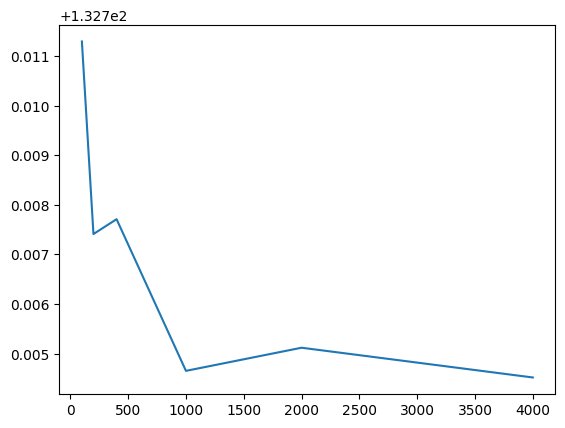

In [25]:
plt.plot(stepsPerYearList,cbPrices);

Copyright (c) 2020 Dominic O'Kane